## 第3章 k近邻法-习题

### 习题3.1
&emsp;&emsp;参照图3.1，在二维空间中给出实例点，画出$k$为1和2时的$k$近邻法构成的空间划分，并对其进行比较，体会$k$值选择与模型复杂度及预测准确率的关系。

**解答：**

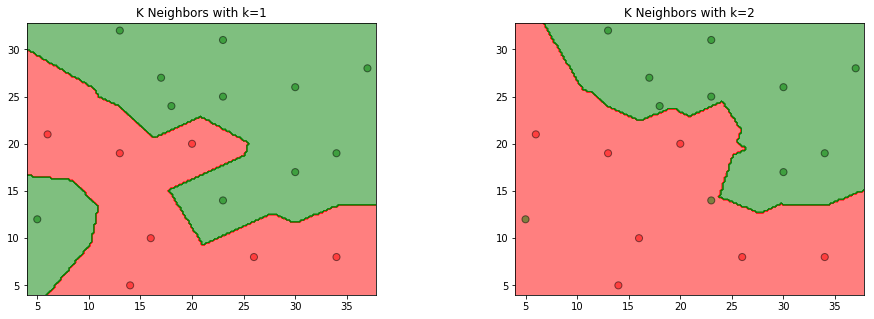

In [1]:
%matplotlib inline
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 

data = np.array([[5, 12, 1],
                [6, 21, 0],
                [14, 5, 0],
                [16, 10, 0],
                [13, 19, 0],
                [13, 32, 1],
                [17, 27, 1],
                [18, 24, 1],
                [20, 20, 0],
                [23, 14, 1],
                [23, 25, 1],
                [23, 31, 1],
                [26, 8, 0],
                [30, 17, 1],
                [30, 26, 1],
                [34, 8, 0],
                [34, 19, 1],
                [37, 28, 1]])
X_train = data[:, 0:2]
y_train = data[:, 2]

models = (KNeighborsClassifier(n_neighbors=1, n_jobs=-1),
          KNeighborsClassifier(n_neighbors=2, n_jobs=-1))
models = (clf.fit(X_train, y_train) for clf in models)

titles = ('K Neighbors with k=1',
          'K Neighbors with k=2')

fig = plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X_train[:, 0], X_train[:, 1]

x_min, x_max = X0.min() - 1, X0.max() + 1
y_min, y_max = X1.min() - 1, X1.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
                         np.arange(y_min, y_max, 0.2))

for clf, title, ax in zip(models, titles, fig.subplots(1, 2).flatten()):    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape) 
    colors = ('red', 'green', 'lightgreen', 'gray', 'cyan')  
    cmap = ListedColormap(colors[:len(np.unique(Z))])  
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)
    
    ax.scatter(X0, X1, c=y_train, s=50, edgecolors='k', cmap=cmap, alpha=0.5)
    ax.set_title(title)

plt.show()

### 习题3.2
&emsp;&emsp;利用例题3.2构造的$kd$树求点$x=(3,4.5)^T$的最近邻点。

**解答：**

In [2]:
import numpy as np
from sklearn.neighbors import KDTree

train_data = np.array([(2, 3), (5, 4), (9, 6), (4, 7), (8, 1), (7, 2)])
tree = KDTree(train_data, leaf_size=2)
dist, ind = tree.query(np.array([(3, 4.5)]), k=1)
x1 = train_data[ind[0]][0][0]
x2 = train_data[ind[0]][0][1]

print("x点的最近邻点是({0}, {1})".format(x1, x2))

x点的最近邻点是(2, 3)


### 习题3.3
&emsp;&emsp;参照算法3.3，写出输出为$x$的$k$近邻的算法。

**解答：**  
**算法：用kd树的$k$近邻搜索**  
输入：已构造的kd树；目标点$x$；    
输出：$x$的最近邻    
1. 在$kd$树中找出包含目标点$x$的叶结点：从根结点出发，递归地向下访问树。若目标点$x$当前维的坐标小于切分点的坐标，则移动到左子结点，否则移动到右子结点，直到子结点为叶结点为止；  
2. 如果“当前$k$近邻点集”元素数量小于$k$或者叶节点距离小于“当前$k$近邻点集”中最远点距离，那么将叶节点插入“当前k近邻点集”；  
3. 递归地向上回退，在每个结点进行以下操作：  
(a)如果“当前$k$近邻点集”元素数量小于$k$或者当前节点距离小于“当前$k$近邻点集”中最远点距离，那么将该节点插入“当前$k$近邻点集”。  
(b)检查另一子结点对应的区域是否与以目标点为球心、以目标点与于“当前$k$近邻点集”中最远点间的距离为半径的超球体相交。如果相交，可能在另一个子结点对应的区域内存在距目标点更近的点，移动到另一个子结点，接着，递归地进行最近邻搜索；如果不相交，向上回退；
4. 当回退到根结点时，搜索结束，最后的“当前$k$近邻点集”即为$x$的最近邻点。

In [3]:
# 构建kd树，搜索待预测点所属区域
from collections import namedtuple
import numpy as np


# 建立节点类
class Node(namedtuple("Node", "location left_child right_child")):
    def __repr__(self):
        return str(tuple(self))


# kd tree类
class KdTree():
    def __init__(self, k=1):
        self.k = k
        self.kdtree = None

    # 构建kd tree
    def _fit(self, X, depth=0):
        try:
            k = self.k
        except IndexError as e:
            return None
        # 这里可以展开，通过方差选择axis
        axis = depth % k
        X = X[X[:, axis].argsort()]
        median = X.shape[0] // 2
        try:
            X[median]
        except IndexError:
            return None
        return Node(
            location=X[median],
            left_child=self._fit(X[:median], depth + 1),
            right_child=self._fit(X[median + 1:], depth + 1)
        )

    def _search(self, point, tree=None, depth=0, best=None):
        if tree is None:
            return best
        k = self.k
        # 更新 branch
        if point[0][depth % k] < tree.location[depth % k]:
            next_branch = tree.left_child
        else:
            next_branch = tree.right_child
        if not next_branch is None:
            best = next_branch.location
        return self._search(point, tree=next_branch, depth=depth + 1, best=best)

    def fit(self, X):
        self.kdtree = self._fit(X)
        return self.kdtree

    def predict(self, X):
        res = self._search(X, self.kdtree)
        return res 

In [4]:
KNN = KdTree()
X_train = np.array([[2, 3],
                    [5, 4],
                    [9, 6],
                    [4, 7],
                    [8, 1],
                    [7, 2]])
KNN.fit(X_train)
X_new = np.array([[3, 4.5]])
res = KNN.predict(X_new)

x1 = res[0]
x2 = res[1]

print("x点的最近邻点是({0}, {1})".format(x1, x2))

x点的最近邻点是(2, 3)
